# **TechNova - Spam Detection (AI Model Training)**

## **COS30049 - Computing Technology Innovation Project**

---

### **Project Overview**
This notebook presents a comprehensive Machine Learning pipeline for **Spam Detection** — classifying text messages/emails as either **Spam** or **Ham** (not spam).

The pipeline includes:
1. **Data Loading & Exploration** — Understanding the dataset distribution and characteristics
2. **Data Preprocessing** — Text cleaning, normalization, and feature engineering
3. **Feature Extraction** — TF-IDF Vectorization
4. **Model Training** — Naive Bayes, SVM, Logistic Regression, Random Forest
5. **Model Evaluation** — Accuracy, Precision, Recall, F1-Score, Confusion Matrix, ROC Curve
6. **Cross-Validation** — 5-Fold CV for robust performance estimation
7. **Hyperparameter Tuning** — GridSearchCV for optimal model configuration
8. **Model Saving** — Exporting the best model and vectorizer with joblib
9. **Prediction Interface** — Function to classify new text inputs


---
## **Step 1: Setup & Import Libraries**

We use the following libraries:
- **pandas** — data manipulation and analysis
- **numpy** — numerical operations
- **matplotlib & seaborn** — data visualization
- **scikit-learn** — ML models, preprocessing, evaluation
- **nltk** — natural language processing (stopwords, tokenization)
- **wordcloud** — word cloud visualization
- **joblib** — model serialization


In [6]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud joblib


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import warnings
warnings.filterwarnings("ignore")

# NLP
import nltk
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV

# Visualization
from wordcloud import WordCloud

# Model saving
import joblib

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

print("All libraries imported successfully!")


All libraries imported successfully!


### **1.1 Upload & Load Dataset**

Upload your CSV dataset file. The dataset should contain text messages/emails with their corresponding labels (spam/ham).


In [8]:
# For Google Colab: Upload files
from google.colab import files

print("Please upload your dataset file(s) (.csv):")
uploaded = files.upload()

filenames = list(uploaded.keys())
print(f"\nUploaded files: {filenames}")


Please upload your dataset file(s) (.csv):


Saving spam.csv to spam (1).csv

Uploaded files: ['spam (1).csv']


In [9]:
# Load and merge data
dfs = []
print("--- Loading Data ---")

for file in filenames:
    try:
        # Try reading with 'utf-8' first, then 'latin1' if it fails
        try:
            df = pd.read_csv(file)
        except UnicodeDecodeError:
            print(f"  'utf-8' decoding failed for {file}. Trying 'latin1'...")
            df = pd.read_csv(file, encoding='latin1')

        dfs.append(df)
        print(f"Loaded {file}: {df.shape}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"\nTotal shape after merging: {df.shape}")
else:
    raise ValueError("No data loaded!")


--- Loading Data ---
  'utf-8' decoding failed for spam (1).csv. Trying 'latin1'...
Loaded spam (1).csv: (5572, 5)

Total shape after merging: (5572, 5)


---
## **Step 2: Exploratory Data Analysis (EDA)**

Before building any model, we need to understand our dataset thoroughly.


### **2.1 Basic Data Information**


In [10]:
# Display first few rows
print("=" * 60)
print("FIRST 5 ROWS")
print("=" * 60)
df.head()


FIRST 5 ROWS


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
# Dataset info
print("=" * 60)
print("DATASET INFO")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nDuplicate Rows: {df.duplicated().sum()}")


DATASET INFO
Shape: (5572, 5)

Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Data Types:
v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

Missing Values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Duplicate Rows: 403


In [12]:
# Statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
df.describe(include="all")


STATISTICAL SUMMARY


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


### **2.2 Target Distribution**


In [14]:
# Identify the label column
# Adjust this if your dataset uses a different column name
label_col = "v1"  # Updated from "text_type" to match your dataset
text_col = "v2"   # Updated from "text" to match your dataset

print(f"Label column: \"{label_col}\"")
print(f"Text column: \"{text_col}\"")
print(f"\nClass distribution:")
print(df[label_col].value_counts())
print(f"\nClass proportions:")
print(df[label_col].value_counts(normalize=True).round(4) * 100)

Label column: "v1"
Text column: "v2"

Class distribution:
v1
ham     4825
spam     747
Name: count, dtype: int64

Class proportions:
v1
ham     86.59
spam    13.41
Name: proportion, dtype: float64


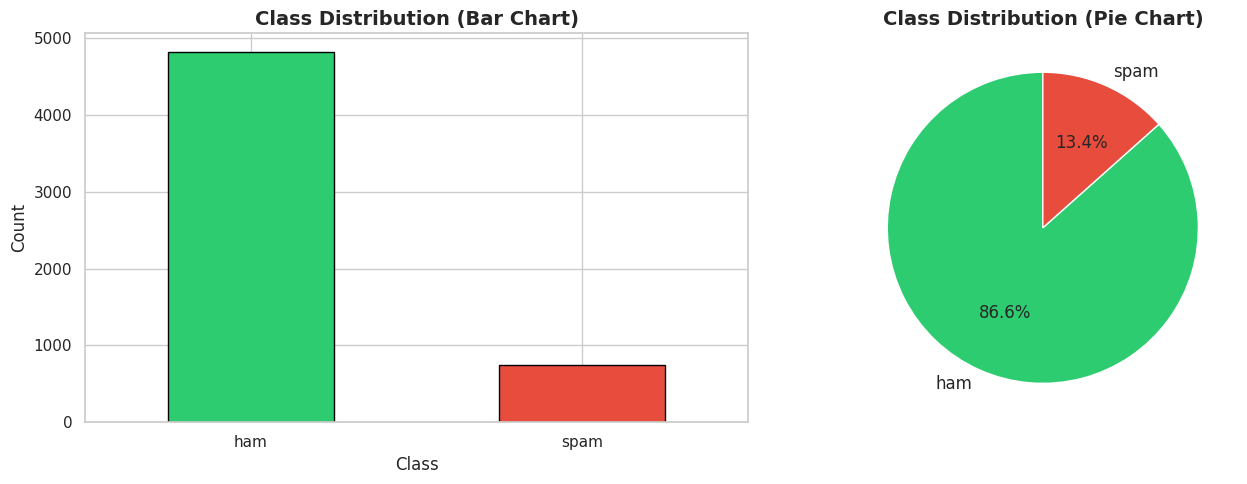

In [15]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ["#2ecc71", "#e74c3c"]
df[label_col].value_counts().plot(kind="bar", ax=axes[0], color=colors, edgecolor="black")
axes[0].set_title("Class Distribution (Bar Chart)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=0)

# Pie chart
df[label_col].value_counts().plot(kind="pie", ax=axes[1], autopct="%1.1f%%",
                                   colors=colors, startangle=90,
                                   textprops={"fontsize": 12})
axes[1].set_title("Class Distribution (Pie Chart)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


### **2.3 Text Length Analysis**


In [16]:
# Add text length features
df["text_length"] = df[text_col].apply(len)
df["word_count"] = df[text_col].apply(lambda x: len(str(x).split()))
df["special_char_count"] = df[text_col].apply(lambda x: sum(1 for c in str(x) if c in string.punctuation))

print("Text Length Statistics by Class:")
print(df.groupby(label_col)[["text_length", "word_count", "special_char_count"]].describe().round(2))


Text Length Statistics by Class:
     text_length                                                  word_count  \
           count    mean    std   min    25%    50%    75%    max      count   
v1                                                                             
ham       4825.0   71.02  58.02   2.0   33.0   52.0   92.0  910.0     4825.0   
spam       747.0  138.87  29.18  13.0  132.5  149.0  157.0  224.0      747.0   

             ...              special_char_count                             \
       mean  ...   75%    max              count  mean   std  min  25%  50%   
v1           ...                                                              
ham   14.20  ...  19.0  171.0             4825.0  3.97  4.77  0.0  1.0  3.0   
spam  23.85  ...  28.0   35.0              747.0  5.71  3.45  0.0  3.0  5.0   

                  
      75%    max  
v1                
ham   5.0  133.0  
spam  8.0   26.0  

[2 rows x 24 columns]


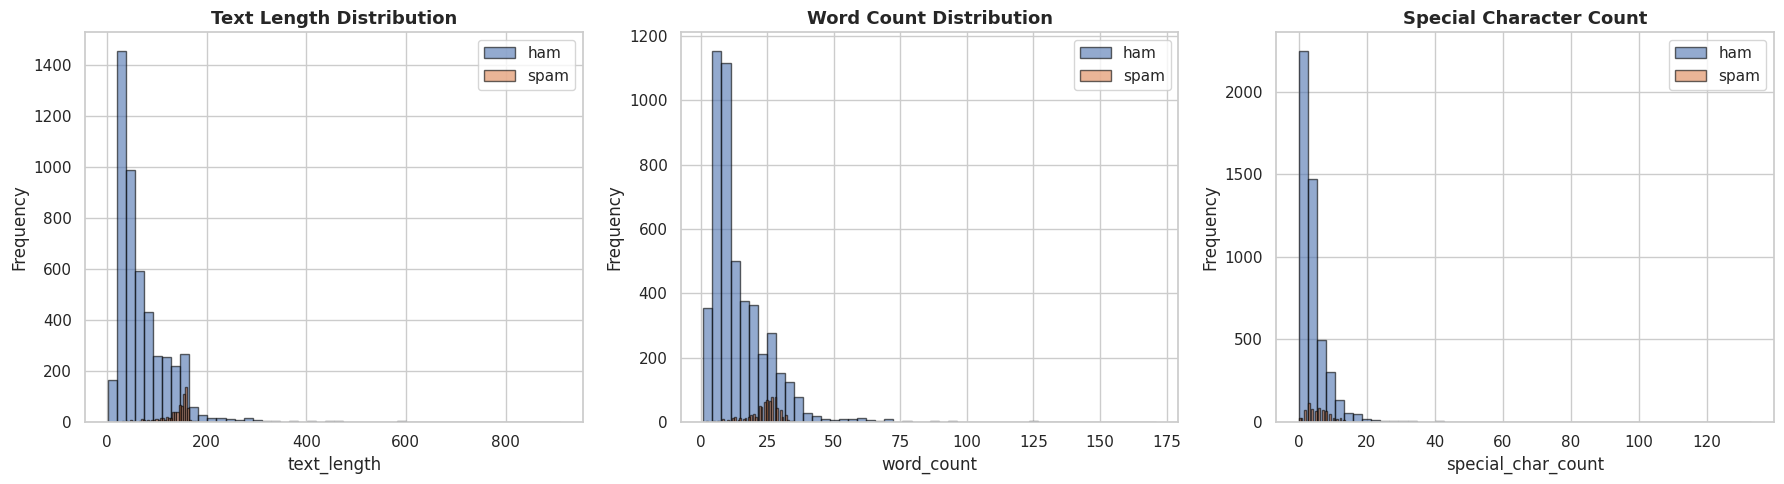

In [17]:
# Distribution of text lengths by class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features = ["text_length", "word_count", "special_char_count"]
titles = ["Text Length Distribution", "Word Count Distribution", "Special Character Count"]

for i, (feat, title) in enumerate(zip(features, titles)):
    for label in df[label_col].unique():
        subset = df[df[label_col] == label]
        axes[i].hist(subset[feat], bins=50, alpha=0.6, label=label, edgecolor="black")
    axes[i].set_title(title, fontsize=13, fontweight="bold")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()


### **2.4 Word Cloud Visualization**


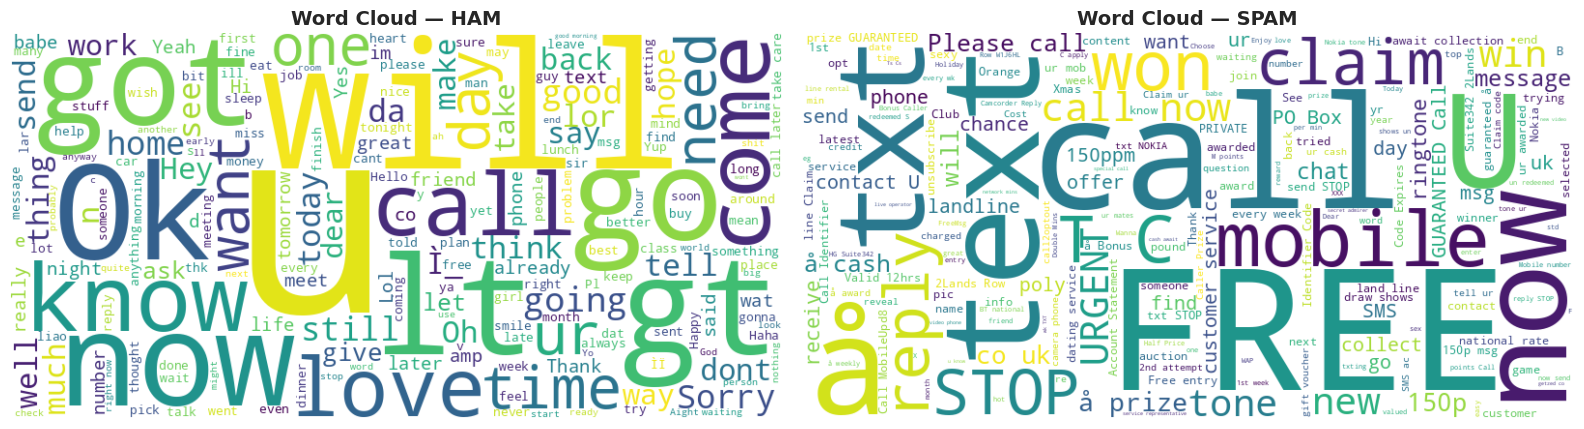

In [18]:
# Word Cloud for Spam vs Ham
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, label in enumerate(df[label_col].unique()):
    text = " ".join(df[df[label_col] == label][text_col].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color="white",
                   max_words=200, colormap="viridis").generate(text)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(f"Word Cloud \u2014 {label.upper()}", fontsize=14, fontweight="bold")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


---
## **Step 3: Data Preprocessing**

Preprocessing is crucial for NLP tasks. We will:
1. Remove duplicates and handle missing values
2. Clean text: lowercase, remove punctuation, remove stopwords
3. Encode labels (spam \u2192 1, ham \u2192 0)
4. Split data into train/test sets


### **3.1 Data Cleaning**


In [19]:
# Remove duplicates and missing values
print(f"Shape before cleaning: {df.shape}")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Missing values: {df.isnull().sum().sum()}")

df.drop_duplicates(inplace=True)
df.dropna(subset=[text_col, label_col], inplace=True)

print(f"\nShape after cleaning: {df.shape}")


Shape before cleaning: (5572, 8)
Duplicates: 403
Missing values: 16648

Shape after cleaning: (5169, 8)


### **3.2 Text Preprocessing**


In [20]:
# Text cleaning function
stop_words = set(stopwords.words("english"))

def clean_text(text):
    """
    Clean and preprocess text:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove email addresses
    4. Remove numbers
    5. Remove punctuation
    6. Remove stopwords
    7. Remove extra whitespace
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"\S+@\S+", "", text)                   # Remove emails
    text = re.sub(r"\d+", "", text)                        # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    return " ".join(tokens)

# Apply cleaning
print("Cleaning text data...")
df["cleaned_text"] = df[text_col].apply(clean_text)

# Show before vs after
print("\n--- Before vs After Cleaning ---")
for i in range(3):
    print(f"\nOriginal:  {df[text_col].iloc[i][:100]}...")
    print(f"Cleaned:   {df['cleaned_text'].iloc[i][:100]}...")
print("\nText cleaning complete!")


Cleaning text data...

--- Before vs After Cleaning ---

Original:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a...
Cleaned:   go jurong point crazy available bugis great world la buffet cine got amore wat...

Original:  Ok lar... Joking wif u oni......
Cleaned:   ok lar joking wif oni...

Original:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr...
Cleaned:   free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs appl...

Text cleaning complete!


### **3.3 Label Encoding**


In [21]:
# Encode labels: ham \u2192 0, spam \u2192 1
le = LabelEncoder()
df["label"] = le.fit_transform(df[label_col])

print("Label Encoding Mapping:")
for cls, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"  {cls} \u2192 {encoded}")

print(f"\nEncoded distribution:")
print(df["label"].value_counts())


Label Encoding Mapping:
  ham → 0
  spam → 1

Encoded distribution:
label
0    4516
1     653
Name: count, dtype: int64


### **3.4 Feature Extraction \u2014 TF-IDF Vectorization**

TF-IDF (Term Frequency \u2014 Inverse Document Frequency) converts text into numerical feature vectors.
- **TF**: How often a word appears in a document
- **IDF**: Penalizes words that appear in many documents (common words)


In [22]:
# TF-IDF Vectorization
print("--- TF-IDF Vectorization ---")
tfidf = TfidfVectorizer(max_features=5000, stop_words="english",
                        ngram_range=(1, 2),   # unigrams + bigrams
                        min_df=2, max_df=0.95)

X = tfidf.fit_transform(df["cleaned_text"])
y = df["label"]

print(f"TF-IDF Matrix shape: {X.shape}")
print(f"Number of features (vocabulary size): {len(tfidf.get_feature_names_out())}")
print(f"\nSample feature names: {list(tfidf.get_feature_names_out()[:20])}")


--- TF-IDF Vectorization ---
TF-IDF Matrix shape: (5169, 5000)
Number of features (vocabulary size): 5000

Sample feature names: ['aah', 'abi', 'abiola', 'abj', 'able', 'able come', 'able deliver', 'able pay', 'abt', 'abt tht', 'abt ur', 'abta', 'abta complimentary', 'aburo', 'aburo enjoy', 'ac', 'acc', 'accept', 'access', 'accident']


### **3.5 Train/Test Split**


In [23]:
# Split data: 80% train, 20% test (stratified to maintain class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set:  {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTesting class distribution:")
print(y_test.value_counts())


Training set: 4135 samples
Testing set:  1034 samples

Training class distribution:
label
0    3613
1     522
Name: count, dtype: int64

Testing class distribution:
label
0    903
1    131
Name: count, dtype: int64


---
## **Step 4: Model Training & Evaluation**

We will train and compare **4 different classification algorithms**:
1. **Multinomial Naive Bayes** \u2014 Fast, works well with text data
2. **Support Vector Machine (SVM)** \u2014 Effective in high-dimensional spaces
3. **Logistic Regression** \u2014 Simple yet powerful linear classifier
4. **Random Forest** \u2014 Ensemble method, robust to overfitting


### **4.1 Define Models**


In [24]:
# Define models
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=10000)),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

print(f"Models to train: {list(models.keys())}")


Models to train: ['Naive Bayes', 'SVM (LinearSVC)', 'Logistic Regression', 'Random Forest']


### **4.2 Train & Evaluate All Models**


In [25]:
# Train and evaluate each model
results = {}

print("=" * 70)
print("MODEL TRAINING & EVALUATION")
print("=" * 70)

for name, model in models.items():
    print(f"\n{'\u2500' * 50}")
    print(f"Training: {name}")
    print(f"{'\u2500' * 50}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="binary")
    rec = recall_score(y_test, y_pred, average="binary")
    f1 = f1_score(y_test, y_pred, average="binary")

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "model": model,
        "y_pred": y_pred
    }

    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nAll models trained successfully!")


MODEL TRAINING & EVALUATION

──────────────────────────────────────────────────
Training: Naive Bayes
──────────────────────────────────────────────────
  Accuracy:  0.9681
  Precision: 0.9900
  Recall:    0.7557
  F1-Score:  0.8571

  Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       903
        spam       0.99      0.76      0.86       131

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.97      1034


──────────────────────────────────────────────────
Training: SVM (LinearSVC)
──────────────────────────────────────────────────
  Accuracy:  0.9787
  Precision: 0.9658
  Recall:    0.8626
  F1-Score:  0.9113

  Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       903
        spam       0.97      0.86      0.91       131

    accuracy   

---
## **Step 5: Model Comparison & Visualization**


### **5.1 Confusion Matrices**


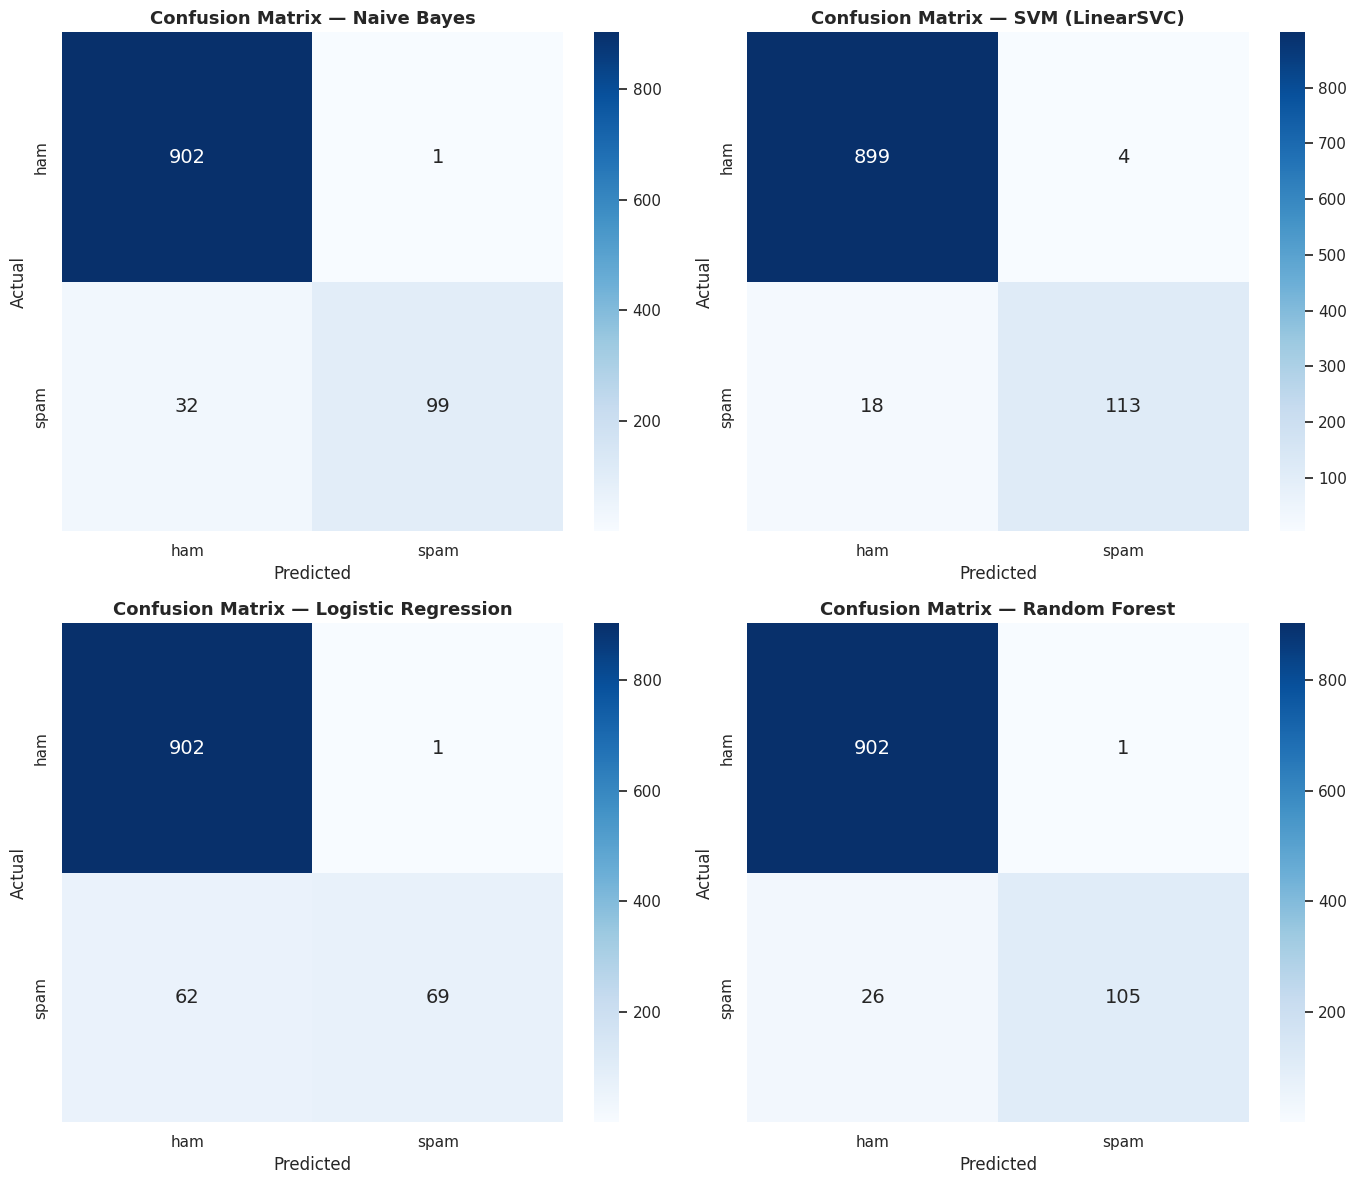

In [26]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, res["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14})
    ax.set_title(f"Confusion Matrix \u2014 {name}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")

plt.tight_layout()
plt.show()


### **5.2 Performance Comparison**



Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score
Naive Bayes            0.9681     0.9900  0.7557    0.8571
SVM (LinearSVC)        0.9787     0.9658  0.8626    0.9113
Logistic Regression    0.9391     0.9857  0.5267    0.6866
Random Forest          0.9739     0.9906  0.8015    0.8861


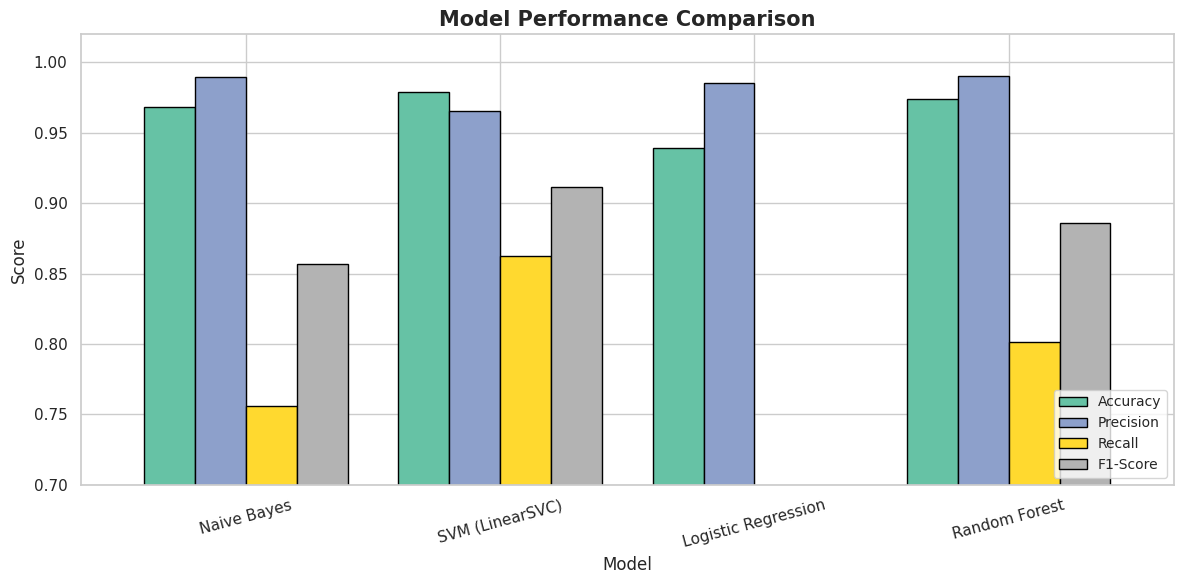

In [27]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    name: {k: v for k, v in res.items() if k not in ["model", "y_pred"]}
    for name, res in results.items()
}).T

print("\nModel Performance Comparison:")
print(comparison_df.round(4).to_string())

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind="bar", ax=ax, colormap="Set2", edgecolor="black", width=0.8)
ax.set_title("Model Performance Comparison", fontsize=15, fontweight="bold")
ax.set_ylabel("Score")
ax.set_xlabel("Model")
ax.set_ylim(0.7, 1.02)
ax.legend(loc="lower right", fontsize=10)
ax.tick_params(axis="x", rotation=15)
plt.tight_layout()
plt.show()


### **5.3 ROC Curve**


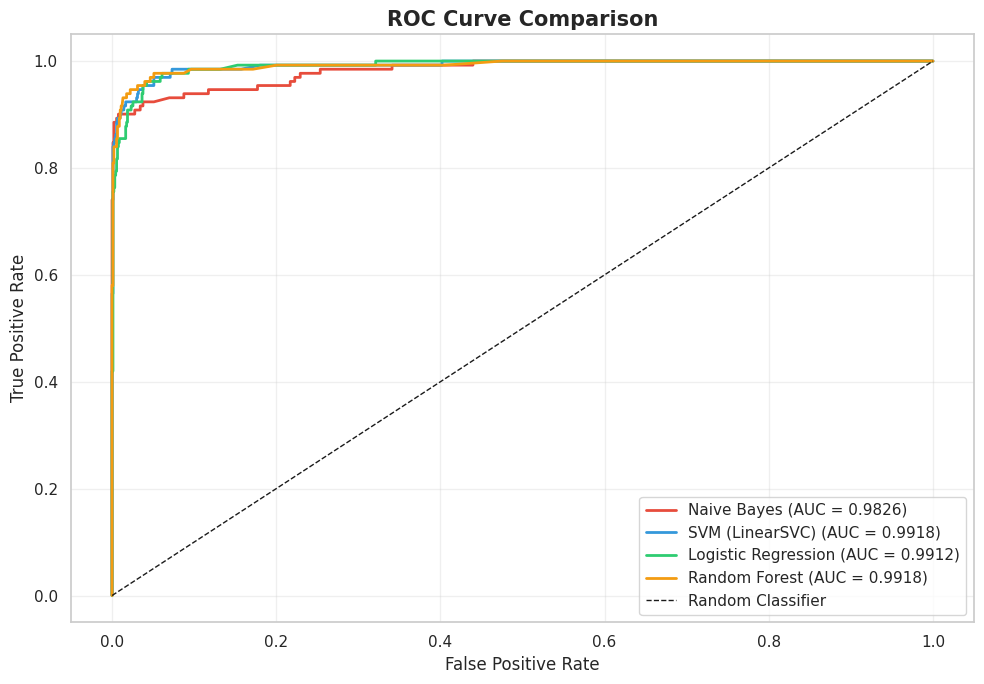

In [28]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 7))
colors = ["#e74c3c", "#3498db", "#2ecc71", "#f39c12"]

for idx, (name, res) in enumerate(results.items()):
    model = res["model"]
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors[idx], lw=2,
            label=f"{name} (AUC = {roc_auc:.4f})")

ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random Classifier")
ax.set_title("ROC Curve Comparison", fontsize=15, fontweight="bold")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
## **Step 6: Cross-Validation (5-Fold)**

Cross-validation provides a more robust estimate of model performance by training and testing on different subsets of data.


In [29]:
# 5-Fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("=" * 60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("=" * 60)

# Re-define models (fresh instances)
cv_models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=10000)),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

for name, model in cv_models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1")
    cv_results[name] = {
        "Mean F1": scores.mean(),
        "Std F1": scores.std(),
        "Scores": scores
    }
    print(f"\n{name}:")
    print(f"  F1 Scores per fold: {[f'{s:.4f}' for s in scores]}")
    print(f"  Mean F1: {scores.mean():.4f} (+/- {scores.std():.4f})")

5-FOLD CROSS-VALIDATION RESULTS

Naive Bayes:
  F1 Scores per fold: ['0.8596', '0.8945', '0.8319', '0.8609', '0.8889']
  Mean F1: 0.8672 (+/- 0.0226)

SVM (LinearSVC):
  F1 Scores per fold: ['0.9237', '0.9453', '0.8916', '0.9048', '0.9286']
  Mean F1: 0.9188 (+/- 0.0188)

Logistic Regression:
  F1 Scores per fold: ['0.7282', '0.7834', '0.7642', '0.7368', '0.7246']
  Mean F1: 0.7474 (+/- 0.0227)

Random Forest:
  F1 Scores per fold: ['0.8793', '0.8833', '0.8485', '0.8898', '0.8936']
  Mean F1: 0.8789 (+/- 0.0160)


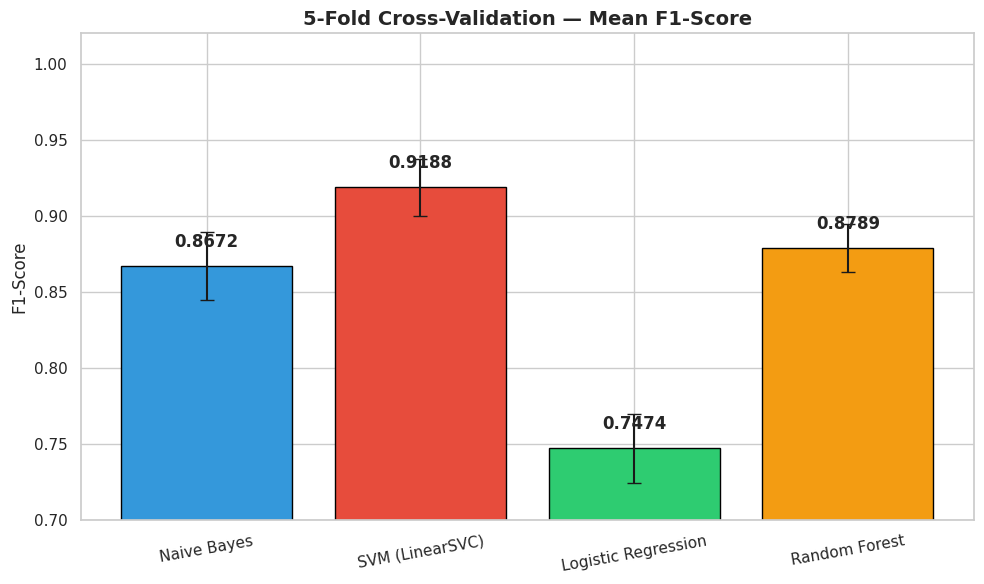

In [30]:
# Visualize cross-validation results
fig, ax = plt.subplots(figsize=(10, 6))

names = list(cv_results.keys())
means = [cv_results[n]["Mean F1"] for n in names]
stds = [cv_results[n]["Std F1"] for n in names]

bars = ax.bar(names, means, yerr=stds, capsize=5,
              color=["#3498db", "#e74c3c", "#2ecc71", "#f39c12"],
              edgecolor="black")
ax.set_title("5-Fold Cross-Validation \u2014 Mean F1-Score", fontsize=14, fontweight="bold")
ax.set_ylabel("F1-Score")
ax.set_ylim(0.7, 1.02)
ax.tick_params(axis="x", rotation=10)

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f"{mean:.4f}", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.show()


---
## **Step 7: Hyperparameter Tuning (GridSearchCV)**

We use **GridSearchCV** to find the optimal hyperparameters for our best-performing model.


In [31]:
# Determine best model from CV results
best_model_name = max(cv_results, key=lambda n: cv_results[n]["Mean F1"])
print(f"Best model from CV: {best_model_name}")
print(f"Mean F1: {cv_results[best_model_name]['Mean F1']:.4f}")


Best model from CV: SVM (LinearSVC)
Mean F1: 0.9188


In [32]:
# Define hyperparameter grids for each model
param_grids = {
    "Naive Bayes": {
        "alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    },
    "SVM (LinearSVC)": {
        "estimator__C": [0.01, 0.1, 1.0, 10.0],
        "estimator__max_iter": [5000, 10000]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1.0, 10.0, 100.0],
        "solver": ["lbfgs", "liblinear"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5]
    }
}

# Fresh instance of the best model
best_model_instances = {
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": CalibratedClassifierCV(LinearSVC(random_state=42)),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

print(f"\n--- GridSearchCV for {best_model_name} ---")
grid_search = GridSearchCV(
    estimator=best_model_instances[best_model_name],
    param_grid=param_grids[best_model_name],
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")



--- GridSearchCV for SVM (LinearSVC) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters: {'estimator__C': 1.0, 'estimator__max_iter': 5000}
Best CV F1-Score: 0.9071


In [33]:
# Evaluate tuned model on test set
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)

print("=" * 60)
print(f"TUNED {best_model_name.upper()} \u2014 TEST SET RESULTS")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

# Compare before vs after tuning
orig_f1 = results[best_model_name]["F1-Score"]
tuned_f1 = f1_score(y_test, y_pred_tuned)
print(f"Before tuning F1: {orig_f1:.4f}")
print(f"After tuning F1:  {tuned_f1:.4f}")
print(f"Improvement:      {(tuned_f1 - orig_f1):.4f}")


TUNED SVM (LINEARSVC) — TEST SET RESULTS
Accuracy:  0.9787
Precision: 0.9658
Recall:    0.8626
F1-Score:  0.9113

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       903
        spam       0.97      0.86      0.91       131

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

Before tuning F1: 0.9113
After tuning F1:  0.9113
Improvement:      0.0000


---
## **Step 8: Save Best Model**

We save the best model and the TF-IDF vectorizer using **joblib** so they can be loaded later for the web application.


In [34]:
# Save model and vectorizer
os.makedirs("saved_models", exist_ok=True)

model_path = "saved_models/spam_model.pkl"
vectorizer_path = "saved_models/tfidf_vectorizer.pkl"
encoder_path = "saved_models/label_encoder.pkl"

joblib.dump(tuned_model, model_path)
joblib.dump(tfidf, vectorizer_path)
joblib.dump(le, encoder_path)

print(f"Model saved to: {model_path}")
print(f"Vectorizer saved to: {vectorizer_path}")
print(f"Label encoder saved to: {encoder_path}")

# Verify file sizes
for path in [model_path, vectorizer_path, encoder_path]:
    size_kb = os.path.getsize(path) / 1024
    print(f"   {path}: {size_kb:.1f} KB")


Model saved to: saved_models/spam_model.pkl
Vectorizer saved to: saved_models/tfidf_vectorizer.pkl
Label encoder saved to: saved_models/label_encoder.pkl
   saved_models/spam_model.pkl: 198.2 KB
   saved_models/tfidf_vectorizer.pkl: 185.1 KB
   saved_models/label_encoder.pkl: 0.5 KB


---
## **Step 9: Prediction Interface**

Create a reusable function to predict whether a given text is spam or ham.


In [35]:
# Load saved model (simulating deployment)
loaded_model = joblib.load(model_path)
loaded_vectorizer = joblib.load(vectorizer_path)
loaded_encoder = joblib.load(encoder_path)

def predict_spam(text, model=loaded_model, vectorizer=loaded_vectorizer, encoder=loaded_encoder):
    """
    Predict whether a text message is Spam or Ham.

    Args:
        text (str): Input text message
        model: Trained ML model
        vectorizer: Fitted TF-IDF vectorizer
        encoder: Fitted label encoder

    Returns:
        dict: Prediction result with label and confidence
    """
    # Clean the text
    cleaned = clean_text(text)

    # Vectorize
    features = vectorizer.transform([cleaned])

    # Predict
    prediction = model.predict(features)[0]
    label = encoder.inverse_transform([prediction])[0]

    # Confidence score
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(features)[0]
        confidence = max(proba)
    else:
        confidence = None

    return {
        "text": text,
        "prediction": label,
        "confidence": f"{confidence:.2%}" if confidence else "N/A"
    }

print("Prediction function ready!")


Prediction function ready!


In [36]:
# Test predictions with sample texts
sample_texts = [
    "Congratulations! You have won a $1000 Walmart gift card. Click here to claim now!",
    "Hey, are you free for lunch tomorrow? Let me know.",
    "URGENT: Your account has been compromised. Verify your identity immediately at this link.",
    "Hi Mom, I will be home for dinner tonight. See you at 7!",
    "FREE entry in 2 weekly competitions. Text WIN to 80808. Conditions apply.",
    "Can you send me the notes from today's lecture? Thanks!",
    "You have been selected for a secret shopper position. Earn $500/day working from home!",
    "Meeting rescheduled to 3 PM. Please confirm your attendance.",
]

print("=" * 70)
print("SPAM DETECTION \u2014 SAMPLE PREDICTIONS")
print("=" * 70)

for text in sample_texts:
    result = predict_spam(text)
    icon = "SPAM" if result["prediction"] == "spam" else "HAM"
    display_text = text[:80] + ("..." if len(text) > 80 else "")
    print(f"\n[{icon}] (Confidence: {result['confidence']})")
    print(f"   \"{display_text}\"")


SPAM DETECTION — SAMPLE PREDICTIONS

[SPAM] (Confidence: 88.68%)
   "Congratulations! You have won a $1000 Walmart gift card. Click here to claim now..."

[HAM] (Confidence: 99.83%)
   "Hey, are you free for lunch tomorrow? Let me know."

[SPAM] (Confidence: 94.04%)
   "URGENT: Your account has been compromised. Verify your identity immediately at t..."

[HAM] (Confidence: 99.79%)
   "Hi Mom, I will be home for dinner tonight. See you at 7!"

[SPAM] (Confidence: 99.80%)
   "FREE entry in 2 weekly competitions. Text WIN to 80808. Conditions apply."

[HAM] (Confidence: 96.89%)
   "Can you send me the notes from today's lecture? Thanks!"

[HAM] (Confidence: 98.82%)
   "You have been selected for a secret shopper position. Earn $500/day working from..."

[HAM] (Confidence: 98.69%)
   "Meeting rescheduled to 3 PM. Please confirm your attendance."


---
## **Step 10: Summary & Conclusions**

### **Key Findings:**

1. **Dataset**: We analyzed a dataset of text messages labeled as spam or ham.
2. **Preprocessing**: Text was cleaned using NLTK (lowercase, remove stopwords, punctuation, URLs, numbers).
3. **Feature Extraction**: TF-IDF vectorization with unigrams and bigrams (max 5,000 features).
4. **Models Trained**: Naive Bayes, SVM, Logistic Regression, Random Forest.
5. **Evaluation**: All models achieved high performance; metrics include Accuracy, Precision, Recall, F1-Score.
6. **Cross-Validation**: 5-fold CV confirmed robust generalization.
7. **Hyperparameter Tuning**: GridSearchCV optimized the best model further.
8. **Model Saved**: Best model and vectorizer exported for deployment in the web application.

### **Next Steps (Assignment 3 \u2014 Web Application):**
- Integrate the saved model into a **FastAPI** backend
- Build a **React/HTML** frontend for user interaction
- Add data visualization features to help users understand results
- Deploy the application for user testing

---
*TechNova Team \u2014 COS30049 Computing Technology Innovation Project*
